Assignment 1 : Pattern Recognition - MNIST dataset

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA as sklearnPCA
import math
from sklearn.metrics import confusion_matrix
import itertools
from itertools import *
from sklearn.naive_bayes import GaussianNB

In [2]:
mnist_train_path = 'MNIST/train.csv'
mnist_test_path = 'MNIST/test.csv'

mnist_train_df = pd.read_csv(mnist_train_path, header=None).T
mnist_test_df = pd.read_csv(mnist_test_path, header=None).T
last_column = mnist_test_df.columns[-1]
mnist_train_df.rename(columns={last_column:'Class'}, inplace=True)
mnist_test_df.rename(columns={last_column:'Class'}, inplace=True)

PCA compressor

In [3]:
def my_pca(X,n_comp):
    cov_mat = np.cov(X.T)
    #print cov_mat.shape

    eig_val, eig_vec = np.linalg.eig(cov_mat)
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    matrix_w = np.hstack(eig_pairs[i][1].reshape(784,1) for i in range(0,n_comp))
    transformed = (matrix_w.T.dot(X.T)).T.real
    #print transformed.shape
    return eig_pairs,matrix_w.real,transformed

LDA compressor

In [100]:
def my_lda_compressor(X,n_class_0,n_class_1,n_comp):
    mean_vector_0 = []
    mean_vector_1 = []
    for i in range(0,784):
        mean_vector_0.append(np.mean(X[0:n_class_0,i]))
        mean_vector_1.append(np.mean(X[n_class_0:,i]))
    mean_vector_0 = np.array(mean_vector_0)
    mean_vector_1 = np.array(mean_vector_1)

    scatter_0 = np.zeros((784,784))
    #for i in range(0,n_class_0):
     #   x = X[i].reshape(784,1)
    #  mean = mean_vector_0.reshape(784,1)
      #  scatter_0 += (x-mean).dot((x-mean).T)
        
    scatter_0 = n_class_0*np.cov(X[0:n_class_0].T)

    scatter_1 = np.zeros((784,784))
    #for i in range(0,n_class_1):
     #   x = X[i+n_class_0].reshape(784,1)
    #   mean = mean_vector_1.reshape(784,1)
      #  scatter_1 += (x-mean).dot((x-mean).T)
        
    scatter_1 = n_class_1*np.cov(X[n_class_0:].T)
    
    scatter_w = scatter_0 + scatter_1
    
    #return mean_vector_0,mean_vector_1,sigma_0,sigma_1

    #w = np.linalg.pinv(sigma_0+sigma_1).dot((mean_vector_1-mean_vector_0).reshape(n_features,1))

    #c = np.dot(w.T,0.5*((mean_vector_1+mean_vector_0).reshape(n_features,1))).flatten()[0]
    #print "Hello"
    
    mat_between = np.zeros((784,784))
    overall_mean = mean_vector_0 + mean_vector_1
    overall_mean = overall_mean / 2.0
    overall_mean = overall_mean.reshape(784,1)
    
    #print "Hi"
    
    mean_vec = mean_vector_0.reshape(784,1)
    mat_between += n_class_0*((mean_vec-overall_mean).dot((mean_vec-overall_mean).T))

    mean_vec = mean_vector_1.reshape(784,1)
    mat_between += n_class_1*((mean_vec-overall_mean).dot((mean_vec-overall_mean).T))
    
    #print mat_between.shape
    #print scatter_w.shape

    eig_vals, eig_vecs = np.linalg.eigh(np.linalg.pinv(scatter_w).dot(mat_between))
   
    
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    W_lda = np.hstack(eig_pairs[i][1].reshape(784,1) for i in range(0,n_comp))
    
    
    X_trans = (W_lda.T.dot(X.T)).T
    
    
    return eig_pairs,W_lda, X_trans

LDA classifier

In [47]:
def lda_classifier(X,n_class_0,n_class_1,n_features):
    mean_vector_0 = []
    mean_vector_1 = []
    for i in range(0,n_features):
        mean_vector_0.append(np.mean(X[0:n_class_0,i]))
        mean_vector_1.append(np.mean(X[n_class_0:,i]))
    mean_vector_0 = np.array(mean_vector_0)
    mean_vector_1 = np.array(mean_vector_1)

    sigma_0 = np.zeros((n_features,n_features))
    for i in range(0,n_class_0):
        x = X[i].reshape(n_features,1)
        mean = mean_vector_0.reshape(n_features,1)
        sigma_0 += (1.0/n_class_0)*((x-mean).dot((x-mean).T))

    sigma_1 = np.zeros((n_features,n_features))
    for i in range(0,n_class_1):
        x = X[n_class_0+i].reshape(n_features,1)
        mean = mean_vector_1.reshape(n_features,1)
        sigma_1 += (1.0/n_class_1)*((x-mean).dot((x-mean).T))
    
    #return mean_vector_0,mean_vector_1,sigma_0,sigma_1

    w = np.linalg.pinv(sigma_0+sigma_1).dot((mean_vector_1-mean_vector_0).reshape(n_features,1))

    c = np.dot(w.T,0.5*((mean_vector_1+mean_vector_0).reshape(n_features,1))).flatten()[0]
    return w,c

Naive Bayes Classifier

In [7]:
def naive_bayes_classifier(X,n_class_0,n_class_1,n_features):
    mean_vector_0 = []
    mean_vector_1 = []
    for i in range(0,n_features):
        mean_vector_0.append(np.mean(X[0:n_class_0:,i]))
        mean_vector_1.append(np.mean(X[n_class_0:,i]))
    mean_vector_0 = np.array(mean_vector_0)
    mean_vector_1 = np.array(mean_vector_1)
    
    mean_vector = np.array([0.0]*n_features, dtype = np.longdouble) #overall
    for i in range(0,n_features):
        mean_vector[i] = (np.mean(X[:,i]))
    variance_vector = np.array([0.0]*n_features, dtype = np.longdouble)
    
    variance_vector = np.var(X,axis=0)
    
    for i in range(0,n_features):
        #var = (np.mean((X_train_01[:,i]-mean_vector[i])**2))
        if variance_vector[i] == 0.0:
            variance_vector[i] = 2.36933947*(10**-30)
        #variance_vector[i] = var

    #prior
    #for class 0
    pi = n_class_0/((n_class_0+n_class_1)*1.0)
    #print "Pi : "+str(pi)
    #for class 1 : 1-pi
    w_0 = math.log((1-pi)/pi)
    #print str(w_0) + "first"
    for i in range(0,n_features):
        w_0 += ((mean_vector_1[i]**2) - (mean_vector_0[i]**2))/(2*variance_vector[i])
        
    w = [0 for i in range(0,n_features)]
    for i in range(0,n_features):
        w[i] = (mean_vector_0[i] - mean_vector_1[i])/variance_vector[i]
    w = np.array(w).reshape(n_features,1)
    w.reshape(n_features,1)
    #print "variance 0: "+str(variance_vector_0[:40])
    #print "variance 1: "+str(variance_vector_1[:40])
    #print "variance :"+str(variance_vector[:40])
    #print "W 0: "+str(w_0)
    #print "W :"+str(w[:40])
    #print w.shape
    return w_0,w

Regularisation pipelines that measure accuracy on the validation set to tune the number of components to be present in the compressed data passed to the classifier for the best accuracy at the cost of increasing components.

In [50]:
def train_regulariser_lda(X_train,X_val,y_val,n_class_0,n_class_1):
    #617 non zero variance features - so check from 0 to 617 components
    accuracy_lda = []
    for n_comp in range(1,300):
        #X_train_trans = my_pca(X_train,n_comp)
        #X_val_trans = my_pca(X_val,n_comp)
        eig_pairs,w_lda,X_train_trans = my_lda_compressor(X_train,n_class_0,n_class_1,n_comp)
        X_val_trans = (w_lda.T.dot(X_val.T)).T
        
        w,c = lda_classifier(X_train_trans,n_class_0,n_class_1,n_comp)
        #print w
        #print c
        acc = 0.0
        for i in range(0,len(X_val_trans)):
            pred = np.dot(w.T,X_val_trans[i].reshape(n_comp,1)).flatten()[0]
            #print pred
            if pred > c:
                pred = 1.0
            else:
                pred = 0.0
            if pred == y_val[i]:
                acc  += 1
        print "Components: " + str(n_comp)+" Accuracy: "+str(acc/len(X_val_trans))
        accuracy_lda.append(acc/len(X_val_trans))
    return accuracy_lda

In [9]:
def train_regulariser_nb(X_train,X_val,y_val,n_class_0,n_class_1):
    accuracy_nb = []
    for n_comp in range(1,300):
        #X_train_trans = my_pca(X_train,n_comp)
        #X_val_trans = my_pca(X_val,n_comp)
        sklearn_pca = sklearnPCA(n_components=n_comp)
        sklearn_pca.fit(X_train)
        X_train_trans = sklearn_pca.transform(X_train)
        X_val_trans = sklearn_pca.transform(X_val)
        w_0,w = naive_bayes_classifier(X_train_trans,n_class_0,n_class_1,n_comp)
        acc = 0.0
        for i in range(0,len(X_val_trans)):
            #print np.dot(w.T,X_val_trans[i].reshape(n_comp,1)).shape
            #print np.dot(w.T,X_val_trans[i].reshape(n_comp,1)).flatten()[0] + w_0
            #print str(i) + ": " + str(np.dot(w.T,X_val_trans[i].reshape(n_comp,1)).flatten()[0] + w_0)
            try:
                pred = math.exp(np.dot(w.T,X_val_trans[i].reshape(n_comp,1)).flatten()[0] + w_0)
            except Exception:
                print "Exception"
                continue
            if pred > 1:
                pred = 0.0
            else:
                pred = 1.0
            if pred == y_val[i]:
                acc  += 1
        print "Components: " + str(n_comp)+" Accuracy: "+str(acc/(len(X_val_trans)-1))
        accuracy_nb.append(acc/(len(X_val_trans)-1))
    return accuracy_nb

Function to plot confusion matrix

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The training, validation and test sets are built. Validation set is used for regularisation to tune the number of components in the compressed data passed to the classifier. In implementing the compression algorithms the whole training set is used.

In [11]:
#building the train and val and test sets

X_train_0 = []
y_train_0 = []
X_train_1 = []
y_train_1 = []
for i in range(0,len(mnist_train_df)):
    if mnist_train_df.at[i,'Class'] in [0,1]:
        vec = mnist_train_df.iloc[[i]].values.flatten().tolist()
        if vec[-1] == 0.0:
            X_train_0.append(vec[:-1])
            y_train_0.append(vec[-1])
        else:
            if vec[-1] == 1.0:
                X_train_1.append(vec[:-1])
                y_train_1.append(vec[-1])
                
                
X_train_0 = np.array(X_train_0)
X_train_1 = np.array(X_train_1)
y_train_0 = np.array(y_train_0)
y_train_1 = np.array(y_train_1)

X_train_01 = np.append(X_train_0[0:len(X_train_0)*7/10],X_train_1[0:len(X_train_1)*7/10],axis=0)
y_train_01 = np.append(y_train_0[0:len(X_train_0)*7/10],y_train_1[0:len(y_train_1)*7/10],axis=0)

X_val_01 = np.append(X_train_0[len(X_train_0)*7/10:],X_train_1[len(X_train_1)*7/10:],axis=0)
y_val_01 = np.append(y_train_0[len(X_train_0)*7/10:],y_train_1[len(X_train_1)*7/10:],axis=0)

X_test_01 = []
y_test_01 = []
for i in range(0,len(mnist_test_df)):
    if mnist_test_df.at[i,'Class'] in [0,1]:
        vec = mnist_test_df.iloc[[i]].values.flatten().tolist()
        X_test_01.append(vec[:-1])
        y_test_01.append(vec[-1])
X_test_01 = np.array(X_test_01)      

PCA : The PCA function implemented above is used for compressing the data.
The most important eigenvector and the 20th eigenvector are constructed below.

In [27]:
eig_pairs_pca,matrix_w,X_train_01_pca = my_pca(np.append(X_train_0,X_train_1,axis=0),200)

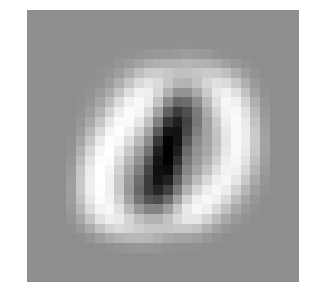

In [13]:
#first eigen vector

plt.figure(figsize=(5,5))
plt.imshow(matrix_w.T[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.axis("off")
plt.show()

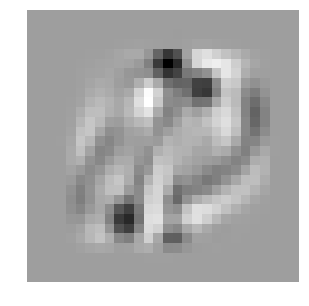

In [14]:
#20th eigen vector

plt.figure(figsize=(5,5))
plt.imshow(matrix_w.T[19].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.axis("off")
plt.show()

LDA : The LDA compressor function implemented above is used for compressing the data. In LDA, there is a transformation matrix for each class.
The most important eigenvector and the 20th eigenvector are constructed below.

In [101]:
eig_pairs_lda,w_lda,X_lda_trans = my_lda_compressor(np.append(X_train_0,X_train_1,axis=0),len(X_train_0),len(X_train_1),200)

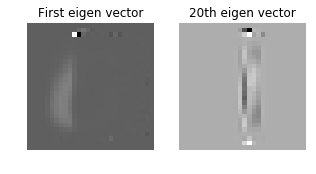

In [54]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(w_lda.T[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.title("First eigen vector")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(w_lda.T[19].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.title("20th eigen vector")
plt.axis("off")
plt.show()

PCA : Plot of cumulative sum of eigen values(divided by total). We can see that the plot plateaus at and thus it is sufficient to retain eigenvalues for compression.

In [28]:
cum_eig_val = []
sum_eig = 0.0
for i in range(0,len(eig_pairs_pca)):
    sum_eig += eig_pairs_pca[i][0]
    cum_eig_val.append(sum_eig)
cum_eig_val = np.array(cum_eig_val)
cum_eig_val = cum_eig_val / sum_eig

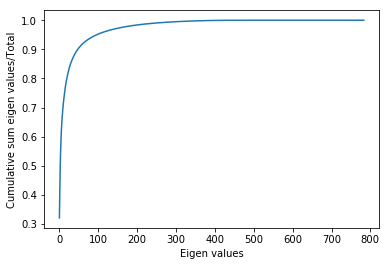

In [102]:
plt.plot([x for x in range(0,len(eig_pairs_pca))],cum_eig_val)
plt.ylabel("Cumulative sum eigen values/Total")
plt.xlabel("Eigen values")
#plt.axis("off")
plt.show()

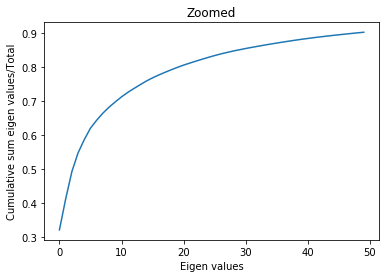

In [103]:
plt.plot([x for x in range(0,50)], cum_eig_val[0:50])
plt.ylabel("Cumulative sum eigen values/Total")
plt.xlabel("Eigen values")
plt.title("Zoomed")
#plt.axis("off")
plt.show()

We can see that right from around 30 eigen values, the slope isn't changing too much and it tapers towards a plateau. Since 30 components hold 90% of the information, it should be enough to get an accurate reconstuction at the cost of including more components.

LDA : Plot of cumulative sum of eigen values(divided by total). We can see that the classwise plots below. Both plots seem to plateau at and thus it is sufficient to retain eigenvalues for compression.

In [34]:
cum_eig_val_lda = []

sum_eig = 0.0
for i in range(0,len(eig_pairs_lda)):
    sum_eig += eig_pairs_lda[i][0]
    cum_eig_val_lda.append(sum_eig)
cum_eig_val_lda = np.array(cum_eig_val_lda)
cum_eig_val_lda = cum_eig_val_lda / sum_eig


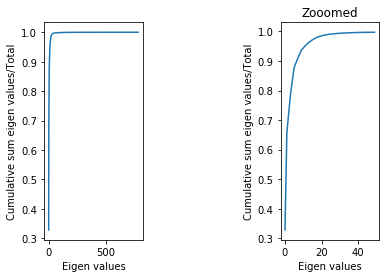

In [115]:
#plt.figure(figsize=(,10))
plt.subplot(1, 3, 1)
plt.plot([x for x in range(0,len(cum_eig_val_lda))],cum_eig_val_lda)
plt.ylabel("Cumulative sum eigen values/Total")
plt.xlabel("Eigen values")
plt.subplot(1, 3, 3)
plt.plot([x for x in range(0,50)],cum_eig_val_lda[0:50])
plt.ylabel("Cumulative sum eigen values/Total")
plt.xlabel("Eigen values")
plt.title("Zooomed")
#plt.axis("off")
plt.show()

Here too, we can see that right from around 30 eigen values, the slope isn't changing too much and it tapers towards a plateau. So 30 components should be enough to get an accurate reconstuction at the cost of including more components.

PCA : Based on the graph, we pick 30 components to do a reconstruction of a test example randomly chosen which is a zero. The left image shows the original and the right two images show the reconstruction with 30 components and the reconstruction error in terms of difference.

In [106]:
eig_pairs,matrix_w,X_train_01_pca = my_pca(np.append(X_train_0,X_train_1,axis=0),30)
#Reconstruction
mean = np.mean(X_train_01,axis=0)
f1 = np.matrix(X_test_01[10])
d = (f1-mean).dot(matrix_w)
wi = np.linalg.pinv(matrix_w)
f2 = d.dot(matrix_w.T) + mean
#print f2.shape

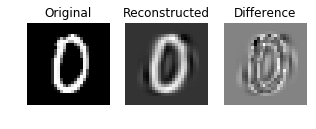

In [107]:
plt.figure(figsize=(5,5))
plt.subplot(1, 3, 1)
plt.imshow(X_test_01[10].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.title("Original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(f2[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.title("Reconstructed")
plt.axis("off")
plt.subplot(1, 3, 3)
diff = normalize(np.array(X_test_01[10], dtype=pd.Series) - f2, axis=1).ravel()
plt.imshow(diff.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); 
plt.title("Difference")
plt.axis("off")
plt.show()

LDA : Based on the graph, we pick 30 components to do a reconstruction of a test example randomly chosen which is a zero. The left image shows the original and the right two images show the reconstruction with 30 components and the reconstruction error in terms of difference.

In [108]:
eig_pairs,w_lda,X_lda_trans = my_lda_compressor(np.append(X_train_0,X_train_1,axis=0),len(X_train_0),len(X_train_1),30)

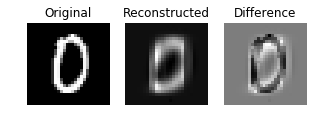

In [109]:
mean = np.mean(np.append(X_train_0,X_train_1,axis=0),axis=0)
f_0 = np.matrix(X_test_01[10])
d = (f_0-mean).dot(w_lda)
wi = np.linalg.pinv(w_lda)
f_0 = d.dot(w_lda.T) + mean
plt.figure(figsize=(5,5))
plt.subplot(1, 3, 1)
plt.imshow(X_test_01[10].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.title("Original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(f_0[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.title("Reconstructed")
plt.axis("off")
plt.subplot(1, 3, 3)
diff = normalize(np.array(X_test_01[10], dtype=pd.Series) - f_0, axis=1).ravel()
plt.imshow(diff.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); 
plt.title("Difference")
plt.axis("off")
plt.show()

We train the lda classifier on 70% of the training data, using the remaining to tune the number of compinents that the lda compressor should compress to and look at the accuracy for 1-300 components to figure out an affordable accuracy at the tradeoff of having more components.

First a sanity check with all 784 components by comparing my implementation accuracy results to the scikit learn library's.

In [75]:
#comparison with library
eig_pairs,w_lda,X_train_trans = my_lda_compressor(X_train_01,len(X_train_0)*7/10,len(X_train_1)*7/10,784)
X_val_trans = (w_lda.T.dot(X_val_01.T)).T
        
w,c = lda_classifier(X_train_trans,len(X_train_0)*7/10,len(X_train_1)*7/10,784)
        #print w
        #print c
        

acc = 0.0
for i in range(0,len(X_val_trans)):
    pred = np.dot(w.T,X_val_trans[i].reshape(784,1)).flatten()[0]
    #print pred
    if pred > c:
        pred = 1.0
    else:
        pred = 0.0
    if pred == y_val_01[i]:
        acc  += 1
print "Components: " + str(784)+" Accuracy: "+str(acc/len(X_val_trans))

Components: 784 Accuracy: 0.993684210526


In [76]:
score_clf2 = 0.0
clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X_train_01, y_train_01)
score_clf2 = clf2.score(X_val_01, y_val_01)
print score_clf2

0.993947368421


The accuracies match fairly well and hence the implementation is good to proceed with.

In [59]:
accuracy_lda = train_regulariser_lda(X_train_01,X_val_01,y_val_01,len(X_train_0)*7/10,len(X_train_1)*7/10)
#accuracy_200 = train_regulariser_lda(X_train_01,X_val_01,y_val_01,len(X_train_0)*7/10,len(X_train_1)*7/10)

Components: 1 Accuracy: 0.968421052632
Components: 2 Accuracy: 0.993157894737
Components: 3 Accuracy: 0.993157894737
Components: 4 Accuracy: 0.993157894737
Components: 5 Accuracy: 0.993157894737
Components: 6 Accuracy: 0.993157894737
Components: 7 Accuracy: 0.993157894737
Components: 8 Accuracy: 0.992894736842
Components: 9 Accuracy: 0.992894736842
Components: 10 Accuracy: 0.992894736842
Components: 11 Accuracy: 0.992894736842
Components: 12 Accuracy: 0.992894736842
Components: 13 Accuracy: 0.993157894737
Components: 14 Accuracy: 0.993421052632
Components: 15 Accuracy: 0.993421052632
Components: 16 Accuracy: 0.993421052632
Components: 17 Accuracy: 0.993684210526
Components: 18 Accuracy: 0.993947368421
Components: 19 Accuracy: 0.993684210526
Components: 20 Accuracy: 0.993684210526
Components: 21 Accuracy: 0.993684210526
Components: 22 Accuracy: 0.993684210526
Components: 23 Accuracy: 0.993684210526
Components: 24 Accuracy: 0.993947368421
Components: 25 Accuracy: 0.993947368421
Component

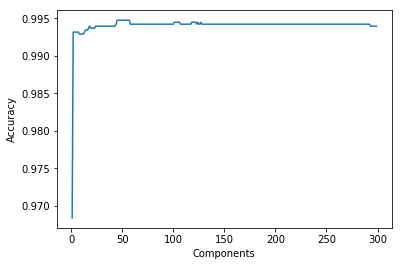

In [60]:
plt.plot([x for x in range(1,300)],accuracy_lda)
plt.xlabel("Components")
plt.ylabel("Accuracy")
plt.show()

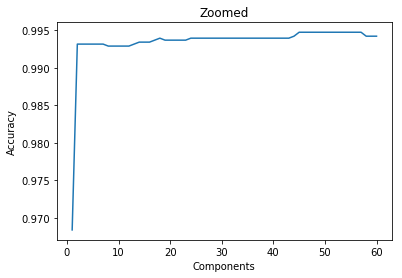

In [116]:
plt.plot([x for x in range(1,61)],accuracy_lda[0:60])
plt.xlabel("Components")
plt.ylabel("Accuracy")
plt.title("Zoomed")
plt.show()

We can see that we have achieved a plateau at around 30 components and a good performance of around 99.395%. We can improve performance only slightly relative to the cost of adding more components in learning.

Now, let's look at the performance of LDA on the test set with the 30 component representation derived from the LDA compressor.

In [78]:
#using just 30 components 
eig_pairs,w_lda,X_train_trans = my_lda_compressor(X_train_01,len(X_train_0)*7/10,len(X_train_1)*7/10,30)
w,c = lda_classifier(X_train_trans,len(X_train_0)*7/10,len(X_train_1)*7/10,30)

X_test_trans = (w_lda.T.dot(X_test_01.T)).T

acc = 0.0
y_pred = []
for i in range(0,len(X_test_trans)):
    pred = np.dot(w.T,X_test_trans[i].reshape(30,1)).flatten()[0]
            #print pred
    if pred > c:
        pred = 1.0
    else:
        pred = 0.0
    y_pred.append(pred)
    if pred == y_test_01[i]:
        acc  += 1
accuracy = confusion_matrix(y_test_01,y_pred)
print "LDA with 30 components : \nAccuracy on test set: " + str(acc/len(X_test_01))

LDA with 30 components : 
Accuracy on test set: 0.993380614657


Confusion matrix, without normalization
[[ 975    5]
 [   9 1126]]
Normalized confusion matrix
[[ 0.99489796  0.00510204]
 [ 0.00792952  0.99207048]]


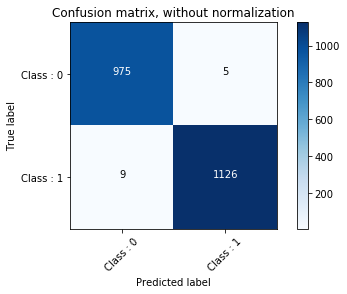

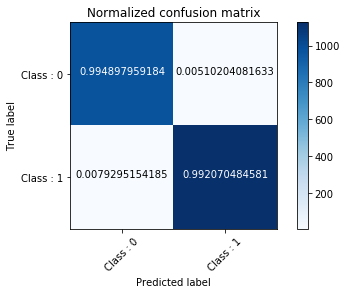

In [79]:
labels = ['Class : 0', 'Class : 1']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Now, let's take a look at the Naive Bayes with gaussian distributions classifier applied to the problem. We'll pass the raw data and use all components and also look at passing PCA compressed data to the classifier and compare performance in terms of accuracy achieved on the validation set. 

First a sanity check with all 784 components by comparing my implementation accuracy results to the scikit learn library's.

Note: There are a 167 pixels with 0 variance and hence do not provide any useful information.

In [83]:
w_0,w = naive_bayes_classifier(X_train_01,len(X_train_0)*7/10,len(X_train_1)*7/10,784)
acc = 0.0
for i in range(0,len(X_val_01)):
    try:
        pred = math.exp(np.dot(w.T,X_val_01[i].reshape(784,1)).flatten()[0] + w_0)
    except Exception:
        print "Exception"
        continue
    if pred > 1:
        pred = 0.0
    else:
        pred = 1.0
    if pred == y_val_01[i]:
        acc  += 1
print "Components: " + str(784)+" Accuracy: "+str(acc/(len(X_val_01)))

Components: 784 Accuracy: 0.99


In [86]:
gnb = GaussianNB().fit(X_train_01,y_train_01)
score = gnb.score(X_val_01, y_val_01)
print score

0.980263157895


I believe the difference in accuracy is due to our simplifying assumption that variance across both classes is the same and usage of a class independent sigma in the algorithm. The library performs classification taking into account class specific sigma vectors.

Let's look at the accuracy of our naive bayes model trained on raw data on the test set.

In [88]:
acc = 0.0
y_pred = []
for i in range(0,len(X_test_01)):
    try:
        pred = math.exp(np.dot(w.T,X_test_01[i].reshape(784,1)).flatten()[0] + w_0)
    except Exception:
        print "Exception"
        continue
    if pred > 1:
        pred = 0.0
    else:
        pred = 1.0
    y_pred.append(pred)
    if pred == y_test_01[i]:
        acc  += 1
accuracy = confusion_matrix(y_test_01,y_pred)
print "Naive Bayes with all components : \nAccuracy on test set: " + str(acc/len(X_test_01))

Naive Bayes with all components : 
Accuracy on test set: 0.993853427896


Confusion matrix, without normalization
[[ 969   11]
 [   2 1133]]
Normalized confusion matrix
[[ 0.98877551  0.01122449]
 [ 0.00176211  0.99823789]]


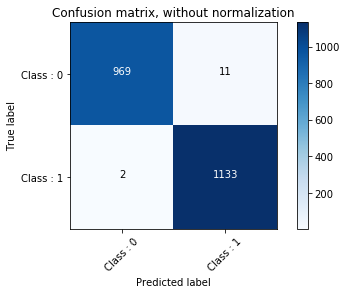

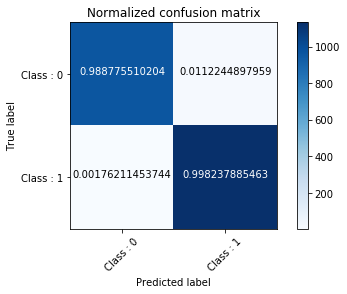

In [89]:
labels = ['Class : 0', 'Class : 1']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Let's now have a look at the performance of the classifier when given the 30 component compressed data from PCA that seemed good enough for reconstruction.

In [110]:
n_comp = 30
sklearn_pca = sklearnPCA(n_components=n_comp)
sklearn_pca.fit(X_train_01)
X_train_trans = sklearn_pca.transform(X_train_01)
X_test_trans = sklearn_pca.transform(X_test_01)
w_0,w = naive_bayes_classifier(X_train_trans,len(X_train_0)*7/10,len(X_train_1)*7/10,n_comp)
     
acc = 0.0
y_pred = []
for i in range(0,len(X_test_trans)):
    try:
        pred = math.exp(np.dot(w.T,X_test_trans[i].reshape(n_comp,1)).flatten()[0] + w_0)
    except Exception:
        print "Exception"
        continue
    if pred > 1:
        pred = 0.0
    else:
        pred = 1.0
    y_pred.append(pred)
    if pred == y_test_01[i]:
        acc  += 1
accuracy = confusion_matrix(y_test_01,y_pred)
print "Naive Bayes with 20 components : \nAccuracy on test set: " + str(acc/len(X_test_01))

Naive Bayes with 20 components : 
Accuracy on test set: 0.999527186761


Confusion matrix, without normalization
[[ 979    1]
 [   0 1135]]
Normalized confusion matrix
[[ 0.99897959  0.00102041]
 [ 0.          1.        ]]


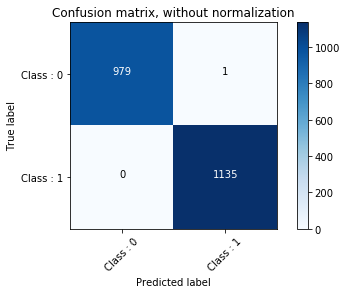

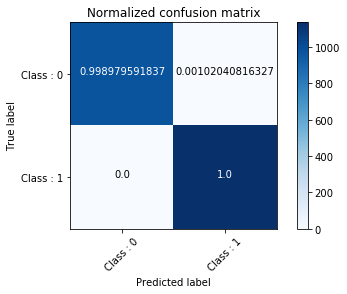

In [111]:
labels = ['Class : 0', 'Class : 1']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Voila, it performs extremely well with a performance of 99.95%. Maybe too many components were adding noise resulting in a worse performance of the classifier!